In [1]:
# %pip install nltk
# %pip install numpy
# %pip install pandas
# %pip install sklearn
# %pip install matplotlib
# %pip install tensorflow

In [7]:
from preprocess import Custom_Preprocessor

import re
import os
import nltk
import pickle
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, SpatialDropout1D

In [8]:
train_df = pd.read_excel("../Scrapper_New/Data_Files/Final/CrimevsNonCrime2.xlsx")
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68934 entries, 0 to 68933
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   68934 non-null  object
 1   Label   68934 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None


In [9]:
print(train_df.describe())

print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

                                                    Title  Label
count                                               68934  68934
unique                                              68393      2
top     Don’t want to play the friend who drives hero ...  Crime
freq                                                    2  35334
All entries unique: False
Null cells: 0


In [10]:
train_df.drop_duplicates(subset=['Title'], inplace=True, ignore_index=True, keep='first')

print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

All entries unique: True
Null cells: 0


In [11]:
Preprocessor = Custom_Preprocessor()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sgfri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
filtered_df = pd.DataFrame(columns=['text', 'label', 'word_count', 'label_name'])

filtered_df['label_name'] = pd.Series(pd.Categorical(train_df['Label']))
filtered_df['label'] = (pd.Categorical(filtered_df['label_name']).codes).astype(int)
label_ids = dict(enumerate(filtered_df['label_name'].cat.categories))

print("Label IDs")
print(label_ids)

filtered_df['text'], filtered_df['word_count'] = Preprocessor.preprocess_data_x(train_df['Title'], get_word_count=True)
filtered_df = filtered_df[filtered_df['word_count']>2]
filtered_df.reset_index(inplace=True)
print(filtered_df.head())

Label IDs
{0: 'Crime', 1: 'Non-Crime'}
   index                                               text  label  \
0      0  villager murdered chhattisgarh police suspect ...      0   
1      1  maha nigerian man wanted drugs case found dead...      0   
2      2           delhi police arrests absconding criminal      0   
3      3            ott show undercover op cop life journey      0   
4      4  internet services suspended days manipur secti...      0   

   word_count label_name  
0           7      Crime  
1          10      Crime  
2           5      Crime  
3           7      Crime  
4           7      Crime  


Crime        35334
Non-Crime    33059
Name: Label, dtype: int64


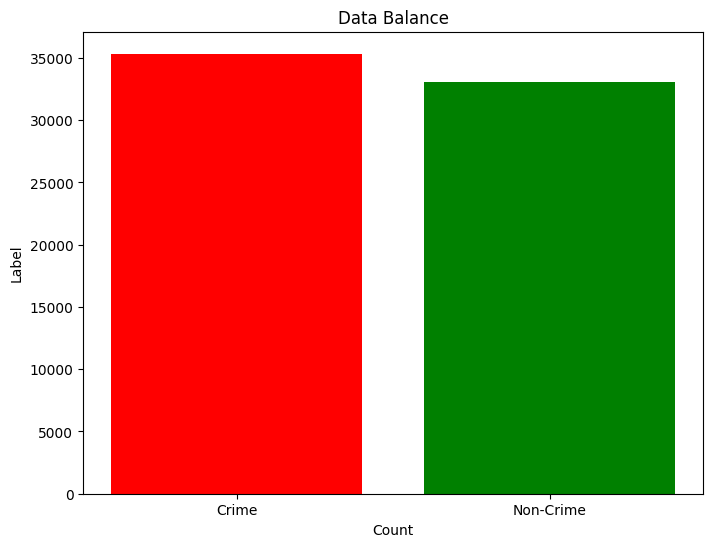

Average Word count: 9.086918903064966
        Max Word Count: 24
        Min Word Count: 3


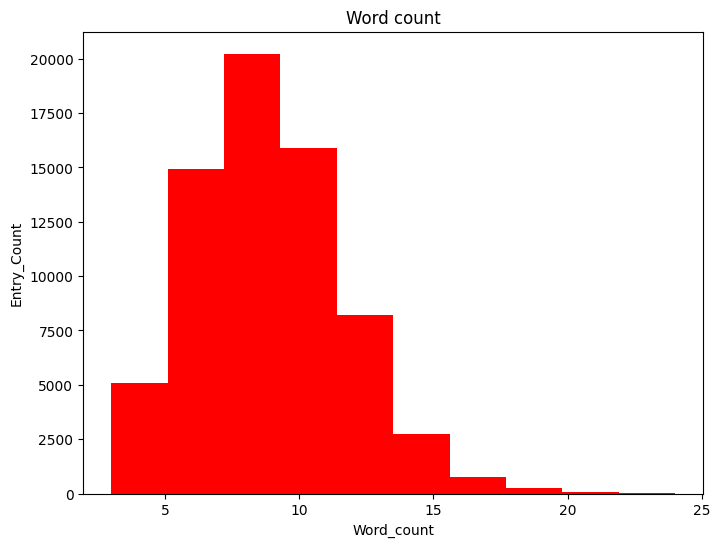

In [13]:
label_counts = train_df['Label'].value_counts()
print(label_counts)

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Data Balance')
plt.show()

print(f'Average Word count: {np.average(filtered_df["word_count"])}\n\
        Max Word Count: {max(filtered_df["word_count"])}\n\
        Min Word Count: {min(filtered_df["word_count"])}')

plt.figure(figsize=(8, 6))
plt.hist(filtered_df['word_count'],color='red')
plt.title('Word count')
plt.xlabel('Word_count')
plt.ylabel('Entry_Count')
plt.show()

In [14]:
MAX_NB_WORDS = 40000
MAX_SEQUENCE_LENGTH = max(filtered_df["word_count"])
EMBEDDING_DIM = 100
TRUNC_TYPE= 'post'
PADDING_TYPE = 'post'
OOV_TOK= '<OOV>'
TEST_SIZE = 0.4
VALIDATION_SIZE = 0.1
LR = 0.00001
DECAY = 1e-6
NUM_EPOCH = 25
BATCH_SIZE = 150

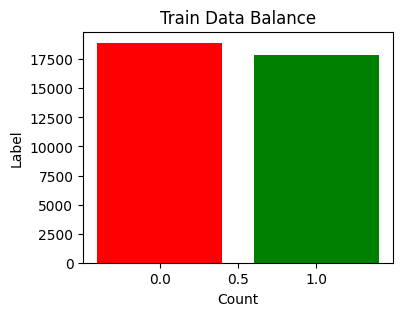

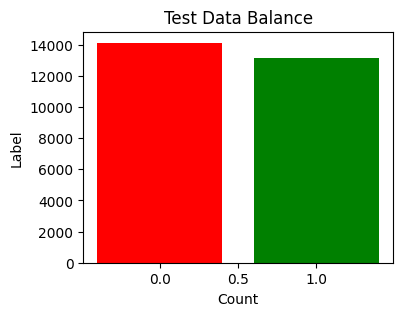

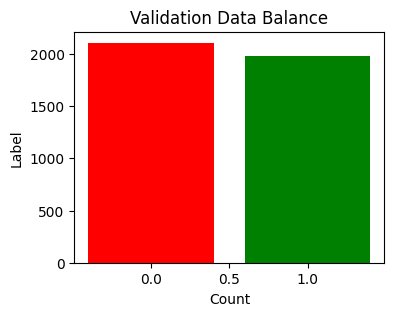

In [15]:
x_train_val,x_test,y_train_val,y_test = train_test_split(filtered_df['text'], filtered_df['label'], test_size=TEST_SIZE,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(x_train_val, y_train_val, test_size=VALIDATION_SIZE,shuffle=True)

train_label_counts = y_train.value_counts()
test_label_counts = y_test.value_counts()
val_label_counts = y_val.value_counts()

plt.figure(figsize=(4, 3))
plt.bar(train_label_counts.index, train_label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Train Data Balance')
plt.show()
plt.figure(figsize=(4, 3))
plt.bar(test_label_counts.index, test_label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Test Data Balance')
plt.show()
plt.figure(figsize=(4, 3))
plt.bar(val_label_counts.index, val_label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Validation Data Balance')
plt.show()

In [ ]:
Preprocessor.set_max_seq_length(MAX_SEQUENCE_LENGTH)

In [16]:
def tokenise(tokenizer, data, maxlen=MAX_SEQUENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE):
    data_sequences = tokenizer.texts_to_sequences(data)
    data_padded = pad_sequences(data_sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    return data_padded

In [17]:
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, oov_token=OOV_TOK)
tokenizer.fit_on_texts(filtered_df['text'])
print(f'Total Entries/Tweets: {len(filtered_df)}\n\
        Total Tokens: {len(tokenizer.word_index)}\n\
        Token Limit: {MAX_NB_WORDS}')

x_train_padded = tokenise(tokenizer, x_train)
x_test_padded = tokenise(tokenizer, x_test)
x_val_padded = tokenise(tokenizer, x_val)

Total Entries/Tweets: 68190
        Total Tokens: 36342
        Token Limit: 40000


In [18]:
model = Sequential()

model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(EMBEDDING_DIM)))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         4000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 100)        0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 4,161,202
Trainable params: 4,161,202
Non-trainable params: 0
_________________________________________________________________


In [19]:
optimizer = Adam(learning_rate=LR, weight_decay=DECAY)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

history = model.fit(
    x_train_padded, y_train,
    epochs=NUM_EPOCH,
    # validation_split=0.1,
    validation_data=(x_val_padded, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001, restore_best_weights=True)],
    verbose=2)

Epoch 1/25
1151/1151 - 98s - loss: 0.6881 - accuracy: 0.5202 - val_loss: 0.6806 - val_accuracy: 0.5437 - 98s/epoch - 85ms/step
Epoch 2/25
1151/1151 - 94s - loss: 0.6496 - accuracy: 0.6392 - val_loss: 0.5990 - val_accuracy: 0.7522 - 94s/epoch - 82ms/step
Epoch 3/25
1151/1151 - 95s - loss: 0.4437 - accuracy: 0.8049 - val_loss: 0.3283 - val_accuracy: 0.8649 - 95s/epoch - 83ms/step
Epoch 4/25
1151/1151 - 100s - loss: 0.2981 - accuracy: 0.8734 - val_loss: 0.3068 - val_accuracy: 0.8768 - 100s/epoch - 87ms/step
Epoch 5/25
1151/1151 - 105s - loss: 0.2707 - accuracy: 0.8892 - val_loss: 0.2956 - val_accuracy: 0.8827 - 105s/epoch - 91ms/step
Epoch 6/25
1151/1151 - 104s - loss: 0.2533 - accuracy: 0.8976 - val_loss: 0.2899 - val_accuracy: 0.8839 - 104s/epoch - 90ms/step
Epoch 7/25
1151/1151 - 100s - loss: 0.2381 - accuracy: 0.9053 - val_loss: 0.2846 - val_accuracy: 0.8859 - 100s/epoch - 86ms/step
Epoch 8/25
1151/1151 - 105s - loss: 0.2236 - accuracy: 0.9117 - val_loss: 0.2781 - val_accuracy: 0.8895

In [20]:
accr = model.evaluate(x_test_padded,y_test)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.2f}'.format(accr[0],accr[1]*100))

853/853 [==============================] - 4s 5ms/step - loss: 0.2673 - accuracy: 0.8910
Test set
  Loss: 0.2673
  Accuracy: 89.10


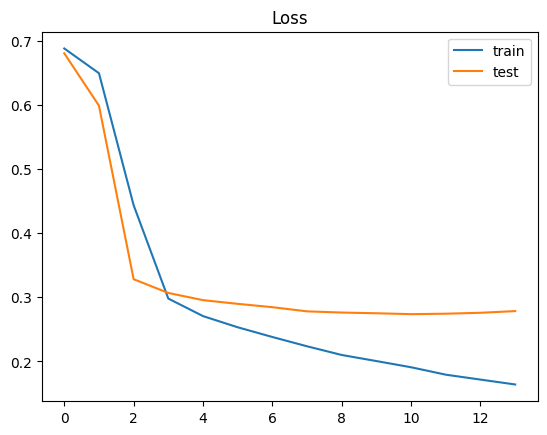

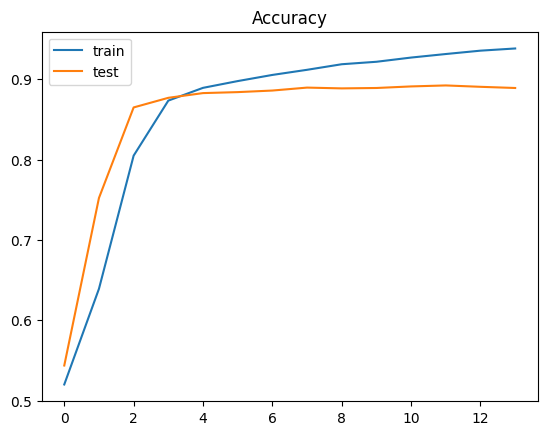

In [24]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [25]:
new_complaints = [
    "Government makes GST compulsory", 
    "Elon Musk Reinstates Twitter Accounts Of Journalists Amid Massive Backlash",
    "Aviral commited theft by stealing my pen",
    "Kartik stabbed his roommate out of spite",
    "Aryan abducted by aliens"
    ]

pre_complaints = Preprocessor.preprocess_data_x(new_complaints)
padded = tokenise(tokenizer, pre_complaints)
pred_list = model.predict(padded)

for i in range(len(new_complaints)):
    pred = pred_list[i]
    print(f'Tweet:\t\t{new_complaints[i]}')
    print(f'Prediction:\t{label_ids[np.argmax(pred)]} {pred}')

1/1 [==============================] - 1s 627ms/step
Tweet:		Government makes GST compulsory
Prediction:	Non-Crime [0.16119416 0.83880585]
Tweet:		Elon Musk Reinstates Twitter Accounts Of Journalists Amid Massive Backlash
Prediction:	Non-Crime [0.05392446 0.94607556]
Tweet:		Aviral commited theft by stealing my pen
Prediction:	Crime [0.9753533  0.02464671]
Tweet:		Kartik stabbed his roommate out of spite
Prediction:	Crime [0.9528218  0.04717821]
Tweet:		Aryan abducted by aliens
Prediction:	Crime [0.9769463 0.0230537]


In [26]:
dir_path = f"./Weights/LSTM/"

if not os.path.isdir(dir_path):
    os.makedirs(dir_path)

dir_path += f'{accr[0]*100:.2f}_{accr[1]*100:.2f}'

if os.path.isdir(dir_path):
    dir_path += '_2'

with open(dir_path+'/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save(dir_path+'/model')
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

INFO:tensorflow:Assets written to: ./Weights/LSTM/26.73_89.10/model\assets


INFO:tensorflow:Assets written to: ./Weights/LSTM/26.73_89.10/model\assets
